# Comparison to iPRG2012 consensus

In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline
import math

import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import squarify
from matplotlib_venn import venn2, venn2_circles

from ann_solo import reader

In [3]:
# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.)    # two-column figure

In [4]:
psms_consensus = pd.read_csv(
    '../../data/external/iprg2012/iprg2012ConsensusSpectrumIDcomparison.tsv',
    sep='\t', header=0, skipfooter=4, engine='python').rename(
    columns={'bestSequence': 'sequence_consensus',
             'Precursor_z': 'charge_consensus'})
# get the same PSM identifiers
psms_consensus = psms_consensus.set_index(psms_consensus['Index1_de'] - 1)
    
psms_annsolo = reader.read_mztab_ssms(
    '../../data/processed/iprg2012/brute_force/bf_oms_shifted.mztab')

In [5]:
psms_annsolo['mass_diff'] = (
    (psms_annsolo['exp_mass_to_charge'] - psms_annsolo['calc_mass_to_charge'])
    * psms_annsolo['charge'])

psms = psms_annsolo[['sequence', 'charge', 'search_engine_score[1]', 'mass_diff']].join(
    psms_consensus[['sequence_consensus', 'charge_consensus']], how='outer')

# don't disambiguate between I and L
for label in ['sequence', 'sequence_consensus']:
    psms[label] = psms[label].str.replace('I', 'L')
# remove SpectraST modification masses
psms['sequence'] = psms['sequence'].str.replace(r'n?\[\d+\]', '')

In [6]:
def edit_distance(seq1, seq2, normed=False):
    if not pd.isnull(seq1) and not pd.isnull(seq2):
        dist = Levenshtein.distance(seq1, seq2)
        if normed:
            dist /= max(len(seq1), len(seq2))
        return dist
    else:
        return math.inf

psms['edit_dist'] = psms.apply(
    lambda psm: edit_distance(psm['sequence'], psm['sequence_consensus']),
    axis=1)
psms['edit_dist_norm'] = psms.apply(
    lambda psm: edit_distance(psm['sequence'], psm['sequence_consensus'], True),
    axis=1)

In [7]:
# get unique keys for spectrum ID - peptide assignment combinations
set_consensus = set(psms.loc[
    psms['sequence_consensus'].notnull(), 'sequence_consensus'].items())
set_annsolo = set(psms.loc[psms['sequence'].notnull(), 'sequence'].items())

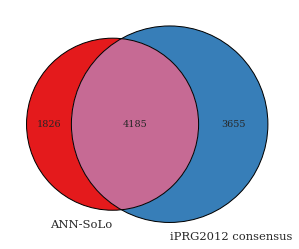

In [8]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

v = venn2([set_annsolo, set_consensus],
          set_labels=['ANN-SoLo', 'iPRG2012 consensus'],
          set_colors=[next(ax._get_lines.prop_cycler)['color'],
                      next(ax._get_lines.prop_cycler)['color']],
          alpha=1., ax=ax)
c = venn2_circles([set_annsolo, set_consensus], linewidth=1.0, ax=ax)

# plt.savefig('iprg2012_consensus_venn.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [9]:
psms_match = psms[psms['sequence_consensus'].notnull() &
                  psms['sequence'].notnull() &
                  (psms['sequence_consensus'] == psms['sequence'])]
psms_different = psms[psms['sequence_consensus'].notnull() &
                      psms['sequence'].notnull() &
                      (psms['sequence_consensus'] != psms['sequence'])]
psms_unique_consensus = (psms[psms['sequence_consensus'].notnull()]
                         .drop(psms_match.index, errors='ignore')
                         .drop(psms_different.index, errors='ignore'))
psms_unique_annsolo = (psms[psms['sequence'].notnull()]
                       .drop(psms_match.index, errors='ignore')
                       .drop(psms_different.index, errors='ignore'))

In [10]:
print(f'# identical PSMs: {len(psms_match)}\n'
      f'# conflicting PSMs: {len(psms_different)}\n'
      f'# unique PSMs ANN-SoLo: {len(psms_unique_annsolo)}\n'
      f'# unique PSMs iPRG2012 consensus: {len(psms_unique_consensus)}')

# identical PSMs: 4185
# conflicting PSMs: 742
# unique PSMs ANN-SoLo: 1084
# unique PSMs iPRG2012 consensus: 2913


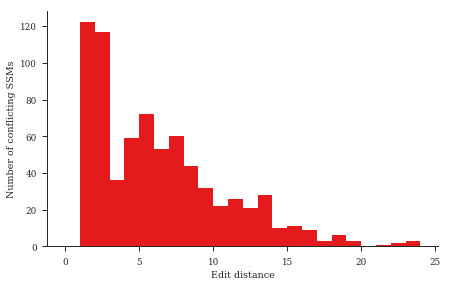

In [11]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

# ax.hist(psms_different['edit_dist_norm'], bins=np.arange(0, 1.05, 0.05))
ax.hist(psms_different['edit_dist'], bins=np.arange(0, 25, 1))

ax.set_xlabel('Edit distance')
ax.set_ylabel('Number of conflicting SSMs')

sns.despine()

plt.savefig('iprg2012_consensus_distance.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [12]:
threshold_different = 3
num_high_sim = len(psms_different[psms_different['edit_dist'] <= threshold_different])
num_low_sim = len(psms_different[psms_different['edit_dist'] > threshold_different])
print(f'# conflicting PSMs with high sequence similarity: {num_high_sim}\n'
      f'# conflicting PSMs with low sequence similarity: {num_low_sim}\n'
      f'    (sequence similarity threshold = {threshold_different} amino acids)')

# conflicting PSMs with high sequence similarity: 275
# conflicting PSMs with low sequence similarity: 467
    (sequence similarity threshold = 3 amino acids)


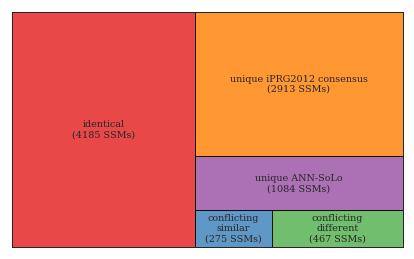

In [13]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

squares = {'identical': len(psms_match),
           'conflicting\nsimilar': num_high_sim,
           'conflicting\ndifferent': num_low_sim,
           'unique ANN-SoLo': len(psms_unique_annsolo),
           'unique iPRG2012 consensus': len(psms_unique_consensus)}
squares = {f'{key}\n({value} SSMs)': value
           for (key, value) in squares.items()}

colors = sns.color_palette('Set1', len(squares))

squarify.plot(sizes=squares.values(), color=colors, label=squares.keys(),
              ax=ax, alpha=0.8, linewidth=1, edgecolor='black')

ax.set_xticks([])
ax.set_yticks([])

plt.savefig('iprg2012_consensus_treemap.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [14]:
peptides_library = set()
filename_pepidx = '../../data/interim/iprg2012/human_yeast_targetdecoy.pepidx'
with open(filename_pepidx) as f_in:
    for line in f_in:
        if not line.startswith('#'):
            peptide, info, _ = line.split()
            charge = info.split('|')[0]
            peptides_library.add((peptide, float(charge)))

In [15]:
psms_notfound = psms_different  # pd.concat([psms_different, psms_unique_consensus])
peptides_notfound = set(zip(psms_notfound['sequence_consensus'],
                            psms_notfound['charge_consensus']))
peptides_notfound_library = peptides_notfound & peptides_library
ions_consensus = psms['sequence_consensus'] + psms['charge_consensus'].map(str)
psms_notfound_library = (psms[ions_consensus.isin(
    [f'{seq}{charge}' for seq, charge in peptides_notfound_library])]
                         .merge(psms_notfound))
peptides_notfound_notlibrary = peptides_notfound - peptides_library
psms_notfound_notlibrary = (psms[ions_consensus.isin(
    [f'{seq}{charge}' for seq, charge in peptides_notfound_notlibrary])]
                            .merge(psms_notfound))
print(f'# conflicting iPRG consensus identification ions not found IN library: '
      f'{len(peptides_notfound_library)} '
      f'({len(psms_notfound_library)} spectra)\n'
      f'# conflicting iPRG consensus identification ions not found NOT IN library: '
      f'{len(peptides_notfound_notlibrary)} '
      f'({len(psms_notfound_notlibrary)} spectra)\n')

# conflicting iPRG consensus identification ions not found IN library: 58 (85 spectra)
# conflicting iPRG consensus identification ions not found NOT IN library: 466 (657 spectra)

